In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
import pandas as pd

features_df = pd.read_csv('/content/drive/MyDrive/features_train_filtered.csv')

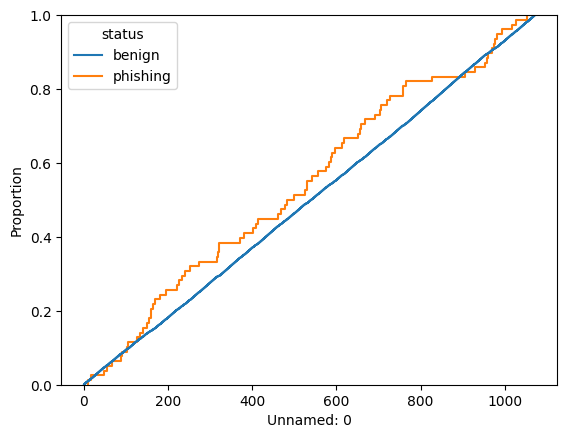

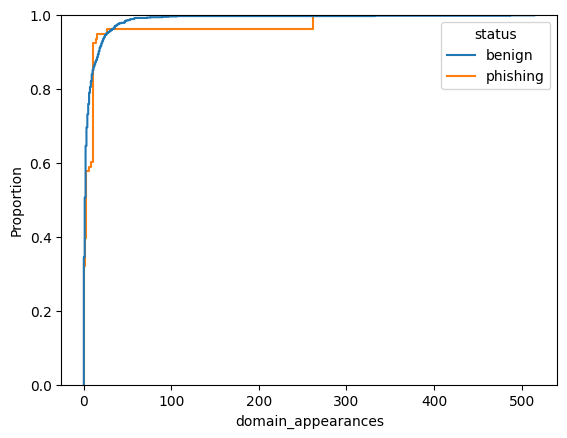

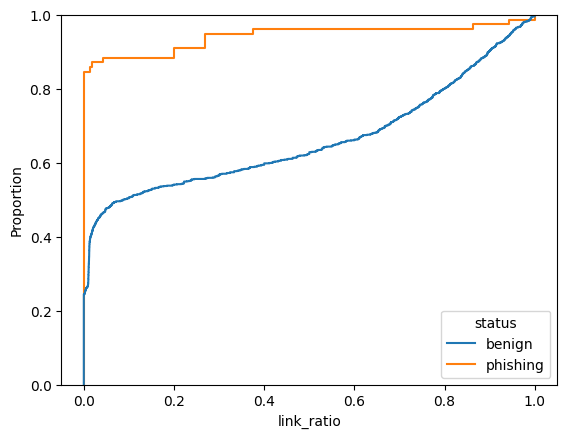

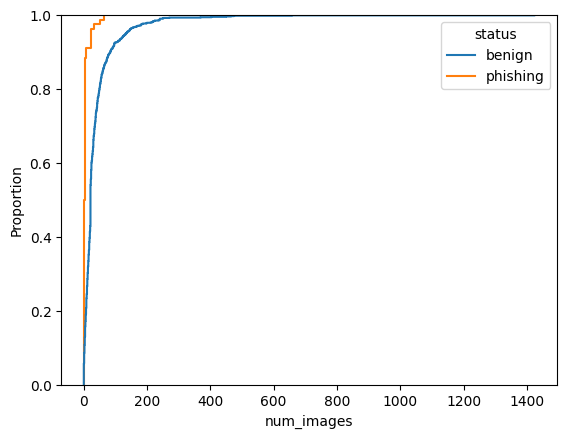

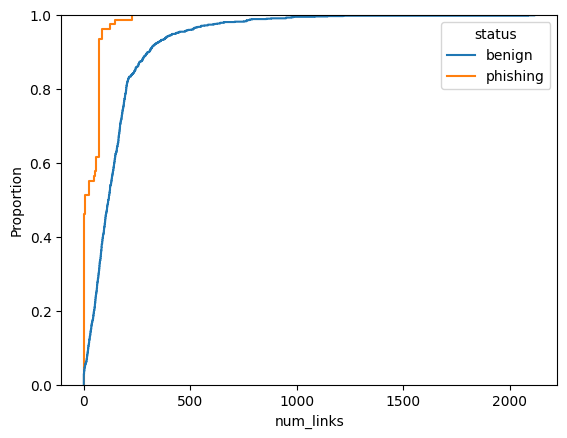

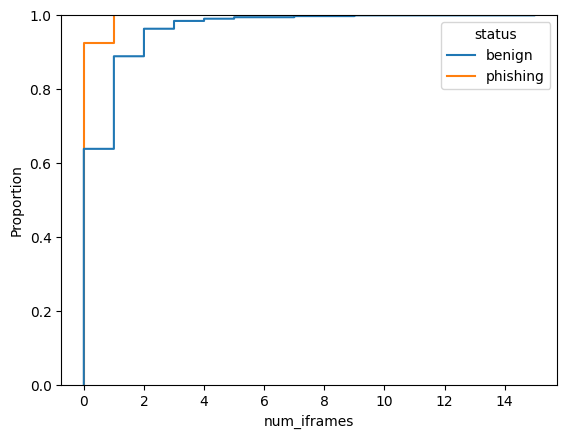

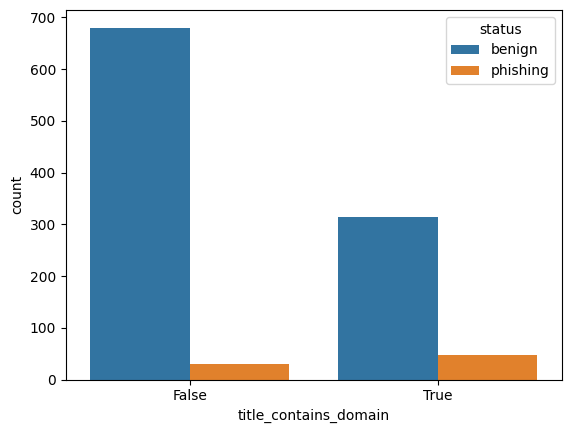

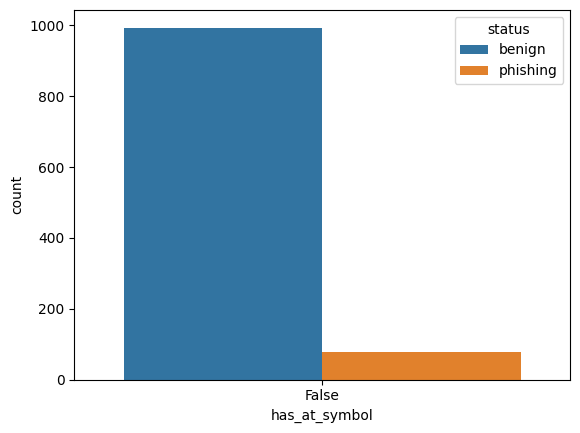

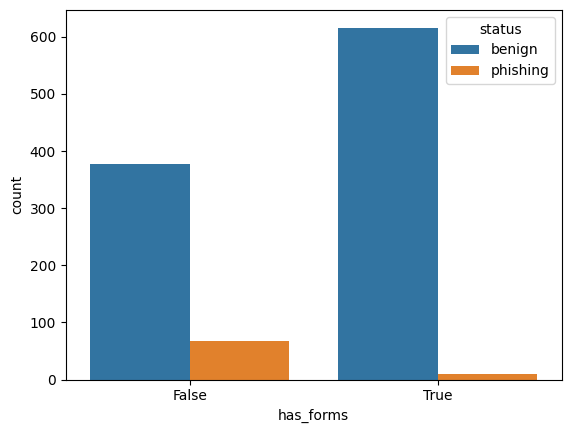

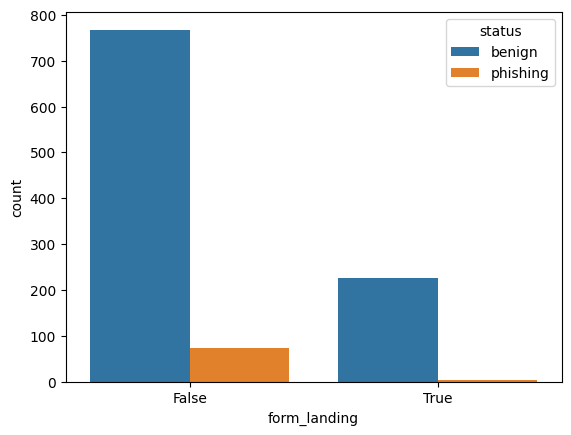

In [ ]:
# prompt: plot ecdf plot for each numerical feature and binary feature distribution for boolean features

import matplotlib.pyplot as plt
import seaborn as sns

# Plot ECDF for each numerical feature
for col in features_df.select_dtypes(include=["int64", "float64"]):
    sns.ecdfplot(data=features_df, x=col, hue='status')
    plt.show()

# Plot binary feature distribution for boolean features
for col in features_df.select_dtypes(include=["bool"]):
    sns.countplot(data=features_df, x=col, hue='status')
    plt.show()


Suggested threshold for feature 'Unnamed: 0': 515.5
Suggested threshold for feature 'domain_appearances': 1.5
Suggested threshold for feature 'link_ratio': 0.0438048245614035
Suggested threshold for feature 'num_images': 11.75
Suggested threshold for feature 'num_links': 61.0
Suggested threshold for feature 'num_iframes': 0.0


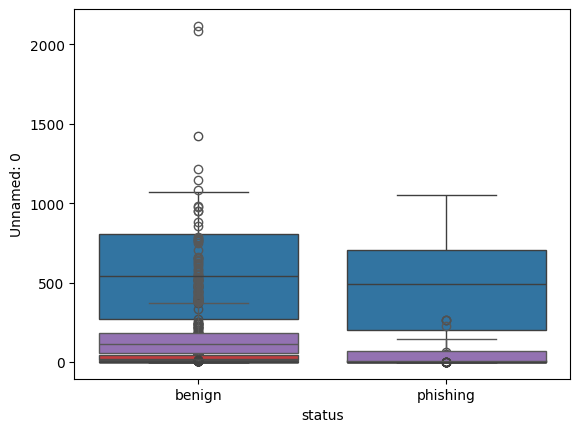

In [ ]:
#@title threshold using median

#Plot boxplot for each feature and suggest threshold
import numpy as np
for col in features_df.select_dtypes(include=["int64", "float64"]):
    sns.boxplot(x="status", y=col, data=features_df)
    #plt.show()

    # Suggest threshold based on the boxplot
    median_class1 = np.median(features_df[features_df['status'] == 'phishing'][col])
    median_class2 = np.median(features_df[features_df['status'] == 'benign'][col])

    threshold = (median_class1+median_class2) / 2

    print(f"Suggested threshold for feature '{col}': {threshold}")

    # Mark data points above/below threshold as phishing/benign
    features_df[col] = features_df[col].apply(lambda x: 1 if x > threshold else -1)

In [ ]:
features_df.to_csv('/content/drive/MyDrive/binary_features_train_med_new.csv')

In [ ]:
#@title using quantile

# Plot boxplot for each feature and suggest threshold
for col in features_df.select_dtypes(include=["int64", "float64"]):
    sns.boxplot(x="status", y=col, data=features_df)
    plt.show()

    # Suggest threshold based on the boxplot
    phishing_q1, phishing_q3 = features_df[features_df['status'] == 'phishing'][col].quantile([0.25, 0.75])
    benign_q1, benign_q3 = features_df[features_df['status'] == 'benign'][col].quantile([0.25, 0.75])

    threshold = (phishing_q1 + phishing_q3 + benign_q1 + benign_q3) / 4

    print(f"Suggested threshold for feature '{col}': {threshold}")

    # Mark data points above/below threshold as phishing/benign
    features_df[col] = features_df[col].apply(lambda x: 1 if x > threshold else -1)

In [ ]:
features_df.to_csv('/content/drive/MyDrive/binary_features_train_another.csv')

In [ ]:
def find_best_gini_split(data, status):
    sorted_indices = np.argsort(data)
    sorted_data = data[sorted_indices]
    sorted_status = status[sorted_indices]

    def calculate_gini_index(split_point, sorted_data, sorted_status):
        # Split the status based on the split point
        left_status = sorted_status[sorted_data <= split_point]
        right_status = sorted_status[sorted_data > split_point]

        # Calculate weights
        total_samples = len(sorted_data)
        left_weight = len(left_status) / total_samples
        right_weight = len(right_status) / total_samples

        # Calculate Gini impurity for left and right subsets
        gini_left = 1 - np.sum(np.square(np.bincount(left_status) / len(left_status)))
        gini_right = 1 - np.sum(np.square(np.bincount(right_status) / len(right_status)))

        # Calculate weighted Gini index
        gini_index = left_weight * gini_left + right_weight * gini_right

        return gini_index

    # Calculate Gini index for all possible split points
    min_gini_index = float('inf')
    min_threshold = None

    for i in range(len(sorted_data) - 1):
        if sorted_data[i]==sorted_data[i+1]:
            continue
        threshold = (sorted_data[i] + sorted_data[i+1]) / 2
        gini_index = calculate_gini_index(threshold, sorted_data, sorted_status)
        if gini_index < min_gini_index:
            min_gini_index = gini_index
            min_threshold = threshold

    return min_threshold

# Calculate the best split point using cross-entropy
def find_best_cross_entropy_split(data, status):
    sorted_indices = np.argsort(data)
    sorted_data = data[sorted_indices]
    sorted_status = status[sorted_indices]

    def calculate_cross_entropy(split_point, sorted_data, sorted_status):
        # Split the status based on the split point
        left_status = sorted_status[sorted_data <= split_point]
        right_status = sorted_status[sorted_data > split_point]

        # Calculate weights
        total_samples = len(sorted_data)
        left_weight = len(left_status) / total_samples
        right_weight = len(right_status) / total_samples

        # Calculate probabilities of each class in left and right subsets
        left_prob_0 = np.sum(left_status == 0) / len(left_status)
        left_prob_1 = np.sum(left_status == 1) / len(left_status)
        right_prob_0 = np.sum(right_status == 0) / len(right_status)
        right_prob_1 = np.sum(right_status == 1) / len(right_status)

        # Calculate cross-entropy for left and right subsets
        left_cross_entropy = -left_prob_0 * np.log(left_prob_0 + 1e-15) - left_prob_1 * np.log(left_prob_1 + 1e-15)
        right_cross_entropy = -right_prob_0 * np.log(right_prob_0 + 1e-15) - right_prob_1 * np.log(right_prob_1 + 1e-15)

        # Calculate weighted cross-entropy
        cross_entropy = left_weight * left_cross_entropy + right_weight * right_cross_entropy

        return cross_entropy

    # Calculate cross-entropy for all possible split points
    min_cross_entropy = float('inf')
    min_threshold = None

    for i in range(len(sorted_data) - 1):
        if sorted_data[i]==sorted_data[i+1]:
            continue
        threshold = (sorted_data[i] + sorted_data[i+1]) / 2
        cross_entropy = calculate_cross_entropy(threshold, sorted_data, sorted_status)
        if cross_entropy < min_cross_entropy:
            min_cross_entropy = cross_entropy
            min_threshold = threshold

    return min_threshold


In [ ]:
features_df = pd.read_csv('/content/drive/MyDrive/features_train_balanced.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/features_train_balanced.csv'

In [ ]:
import numpy as np
status = features_df['status']
status = status.replace('benign',0)
status = status.replace('phishing',1)

for col in features_df.select_dtypes(include=["int64", "float64"]):
    # sns.boxplot(x="status", y=col, data=features_df)

    # plt.show()
    data = features_df[col].values

    min_split = np.min(data)
    max_split = float(np.max(data))
    split_points = np.arange(min_split,max_split)
    print(min_split)
    print(max_split)
    threshold = find_best_cross_entropy_split(data,status)
    # Suggest threshold based on the boxplot



    print(f"Suggested threshold for feature '{col}': {threshold}")
    if threshold == None:
        continue
    # Mark data points above/below threshold as phishing/benign
    features_df[col] = features_df[col].apply(lambda x: 1 if x > threshold else -1)

In [ ]:
features_df.to_csv('/content/drive/MyDrive/Phishing_URL_detection/binary_features_train_entropy.csv')

In [ ]:
features_df

,Unnamed: 0,url,domain_appearances,title_contains_domain,link_ratio,has_forms,form_landing,num_images,num_links,num_iframes,num_subdomain_level,has_sensitive_word,num_terms_in_title,max_dom_depth,dom_node_count,status
0,-1,http://seguridad-bancolombia.012.zya.me/?i=1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,phishing
1,-1,https://new.express.adobe.com/webpage/7Axg1Qim...,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,phishing
2,-1,https://mail-103653.weeblysite.com/,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,phishing
3,-1,https://nuclide.io/,1,1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,benign
4,-1,https://sky-108197.weeblysite.com/,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,phishing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924,1,https://www.techspotty.com/,1,-1,1,1,1,1,1,-1,1,-1,-1,1,1,benign
1925,1,https://www.kirkwood.com/,1,1,1,1,-1,1,1,-1,1,-1,1,1,1,benign
1926,1,https://www.mollie.com/nl/,1,1,-1,-1,-1,1,1,-1,1,-1,1,1,1,benign
1927,1,https://www.ufasvet.ru/,1,-1,-1,1,-1,1,1,-1,1,-1,-1,1,1,benign


In [ ]:
features_df

,Unnamed: 0,url,domain_appearances,title_contains_domain,link_ratio,has_forms,form_landing,num_images,num_links,num_iframes,num_subdomain_level,has_sensitive_word,num_terms_in_title,max_dom_depth,dom_node_count,status
0,-1,http://seguridad-bancolombia.012.zya.me/?i=1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,phishing
1,-1,https://new.express.adobe.com/webpage/7Axg1Qim...,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,phishing
2,-1,https://mail-103653.weeblysite.com/,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,phishing
3,-1,https://nuclide.io/,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,benign
4,-1,https://sky-108197.weeblysite.com/,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,phishing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924,1,https://www.techspotty.com/,1,-1,1,1,1,1,1,-1,1,-1,-1,1,1,benign
1925,1,https://www.kirkwood.com/,1,1,-1,1,-1,1,1,-1,1,-1,1,1,1,benign
1926,1,https://www.mollie.com/nl/,1,1,-1,-1,-1,1,1,-1,1,-1,1,1,1,benign
1927,1,https://www.ufasvet.ru/,1,-1,-1,1,-1,1,1,-1,1,-1,-1,1,1,benign
